In [141]:
import os
import sys
from collections import OrderedDict
sys.path.append("../..")
import spatialpy
spatialpy.__file__
import matplotlib.pyplot as plt
import numpy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
class Teleport(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[0] > system->xhi){
            me->x[0] = system->xlo+0.01;
        }
        me->x[2] = 0;
        me->rho = 1.0;
        """

In [143]:
class weir(spatialpy.Model):
    def __init__(self, model_name="weir_aka_backward_facing_step"):
        spatialpy.Model.__init__(self, model_name)


        xmax = 35
        ymax = 10

        # Construct mesh for backward facing step
        self.mesh = spatialpy.Mesh(0, xlim=(0,xmax), ylim=(0,ymax), zlim=(0,0), gravity=[0,-1,0])
        for x in numpy.linspace(0, xmax):
            for y in numpy.linspace(0, ymax):
                if y == 0 or y == 10:
                    self.mesh.add_point([x,y,0], type=1, mass=1.0, vol=1.0, nu=1.0, fixed=True)
                elif y > 0 and y < 10 and x > 1 and x < 10:
                    self.mesh.add_point([x,y,0], type=2, mass=1.0, vol=1.0, nu=1.0, fixed=False)
                elif x >= 10 and x <= 15 and y > 0 and y < 5:
                    self.mesh.add_point([x,y,0], type=1, mass=1.0, vol=1.0, nu=1.0, fixed=True)
                elif x == 0:
                    self.mesh.add_point([x,y,0], type=1, mass=1.0, vol=1.0, nu=1.0, fixed=True)



        # Teleport particles back to start to simulate flow
        self.add_boundary_condition(Teleport())

        self.staticDomain = False

        # Define time parameters
        self.timestep_size = 1e-3  # timestep size
        self.num_timesteps = 50000    # number of timesteps
        self.output_freq = 250      # frequency of outputting results

In [144]:
model = weir()

In [145]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
sol.compile()

In [146]:
%time result = sol.run()

CPU times: user 5.8 ms, sys: 16.1 ms, total: 21.9 ms
Wall time: 2min 17s


In [147]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(time=0,key='type',index=0):
    try:
        pts, data = result.read_step(time)
    except Exception:
        print("error reading time={0}".format(time))
        return
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('image')
    #plt.colorbar()
    plt.title('time={0}'.format(time*model.timestep_size*model.output_freq))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)
    plt.xlim(result.model.mesh.xlim)
    plt.ylim(result.model.mesh.ylim)
    
    
    
def plot_all(key='type',index=0):
    for i,t in enumerate(result.get_timespan()):
        if i % 10 == 0:
            plot_step(i,key,index)

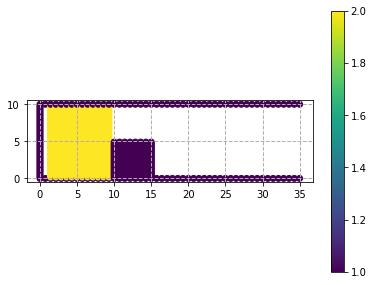

In [148]:
result.plot_property("type", t_ndx=0, use_matplotlib=True, mpl_width=6.4, mpl_height=4.8)

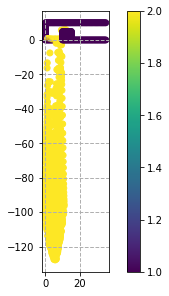

In [150]:
result.plot_property("type", t_ndx=75, use_matplotlib=True, mpl_width=6.4, mpl_height=4.8)